In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns # pyplot theme 정해줌
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

In [ ]:
import tensorflow as tf

In [ ]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [ ]:
dataDir = '/content/gdrive/My Drive/Colab Notebooks/chest_xray'
trainDir = '/content/gdrive/My Drive/Colab Notebooks/chest_xray/train'
valDir = '/content/gdrive/My Drive/Colab Notebooks/chest_xray/val'
testDir = '/content/gdrive/My Drive/Colab Notebooks/chest_xray/test'

In [ ]:
# 경로만 가짐
normalCasesDir = '/content/gdrive/My Drive/Colab Notebooks/chest_xray/train/NORMAL' 
pneumoniaCasesDir = '/content/gdrive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA' 


# 디렉토리 안에 들어있는 전체 파일리스트 생성
# 파일명만 가짐
normalCases = os.listdir(normalCasesDir)
pneumoniaCases = os.listdir(pneumoniaCasesDir)

In [ ]:
for i in range(len(normalCases)):
  normalCases[i] = os.path.join(normalCasesDir, normalCases[i])
  
  
for i in range(len(pneumoniaCases)):
  pneumoniaCases[i] = os.path.join(pneumoniaCasesDir, pneumoniaCases[i])
  
# 경로 + 파일명 합침

In [ ]:
trainData = []

for img in normalCases :
  trainData.append((img,0)) # train data 에서 normal은 0 으로 라벨링

for img in pneumoniaCases :
  trainData.append((img,1)) # pneumonia 는 1 로 라벨링

In [ ]:
# list 에 있는 data로부터 pandas dataframe 을 가져옴 
trainData = pd.DataFrame(trainData, columns=['image','label'], index = None)

# shuffle the data
trainData = trainData.sample(frac = 1.).reset_index(drop=True)

trainData.head()

,image,label
0,/content/gdrive/My Drive/Colab Notebooks/chest...,1
1,/content/gdrive/My Drive/Colab Notebooks/chest...,1
2,/content/gdrive/My Drive/Colab Notebooks/chest...,0
3,/content/gdrive/My Drive/Colab Notebooks/chest...,1
4,/content/gdrive/My Drive/Colab Notebooks/chest...,0


1    3024
0    1342
Name: label, dtype: int64


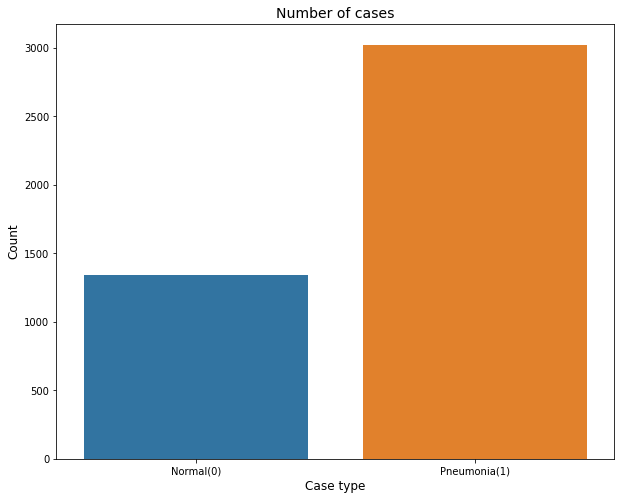

In [ ]:
casesCount = trainData['label'].value_counts()
print(casesCount)

plt.figure(figsize = (10,8))
sns.barplot(x=casesCount.index, y= casesCount.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(casesCount.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

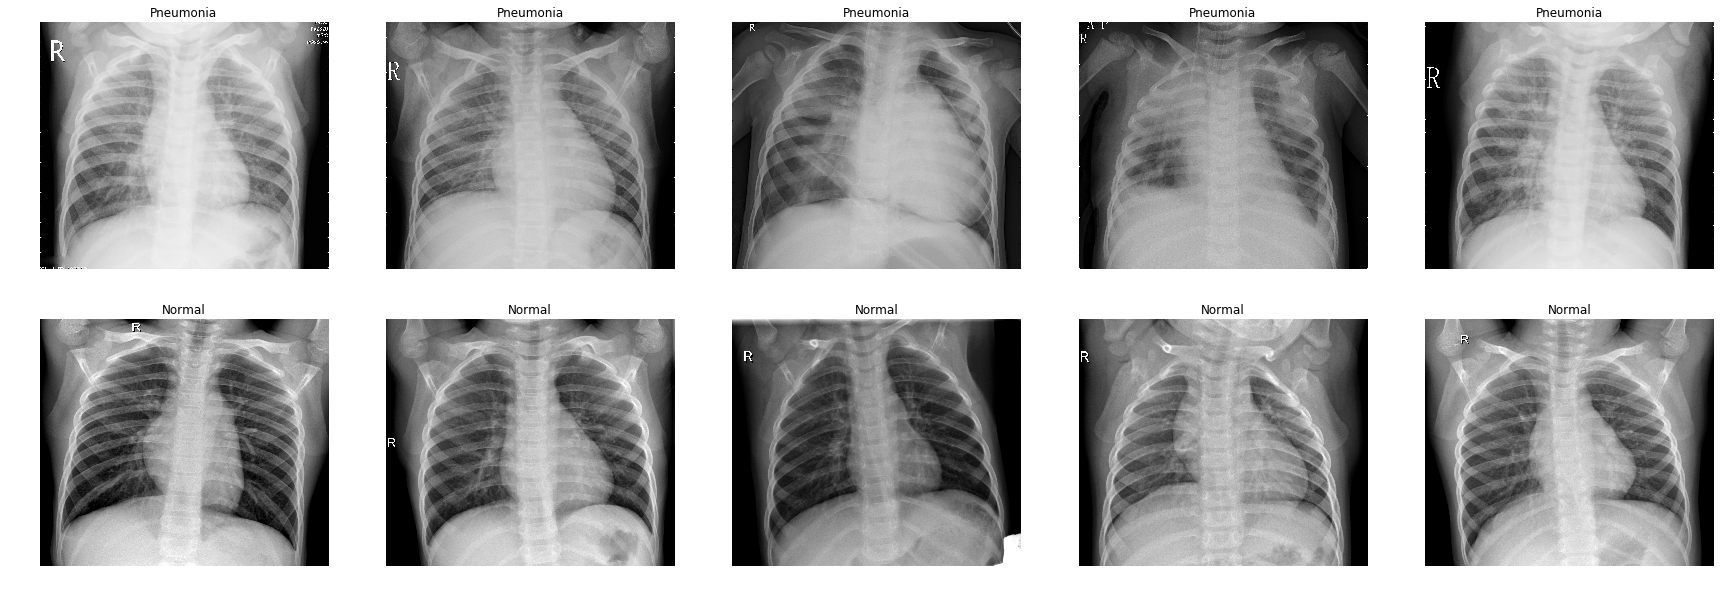

In [ ]:
pneumoniaSamples = (trainData[trainData['label'] == 1]['image'].iloc[:5]).tolist()
normalSamples = (trainData[trainData['label'] == 0]['image'].iloc[:5]).tolist()
# 1 이면 폐렴 img 5개의 경로 가져옴, 0 이면 정상 img 5개의 경로 가져옴

samples = pneumoniaSamples + normalSamples

f,ax = plt.subplots(2,5, figsize = (30,10))

for i in range(10):
  img = imread(samples[i])
  ax[i//5, i%5].imshow(img,cmap = 'gray')
  if i<5:
    ax[i//5, i%5].set_title('Pneumonia') # ax[i//5, i%5] -> 폐렴은 0 행에 출력
  else :
    ax[i//5, i%5].set_title('Normal') # 정상은 1행에 추력
    
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_aspect('auto')
  
plt.show()

In [ ]:
normal_cases_dir = '/content/gdrive/My Drive/datasets/Colab Notebooks/chest_xray/val/NORMAL'
pneumonia_cases_dir = '/content/gdrive/My Drive/datasets/Colab Notebooks/chest_xray/val/PNEUMONIA'
# validation data 만들기

normalCases = os.listdir(normalCasesDir)
pneumoniaCases = os.listdir(pneumoniaCasesDir)


for i in range(len(normalCases)):
  normalCases[i] = os.path.join(normalCasesDir, normalCases[i])
  
for i in range(len(pneumoniaCases)):
  pneumoniaCases[i] = os.path.join(pneumoniaCasesDir,pneumoniaCases[i])

In [ ]:
validData = []
validLabels = []

In [ ]:
for img in normalCases:
  img = cv2.imread(img) # img 읽어옴
  img = cv2.resize(img, (224,224))
  
  if img.shape[2] == 1 : # channel 1 -> gray scale
    img = np.dstack([img,img,img]) # channel 에 영상 쌓음 -> rgb 같이 똑같은 거 3번 쌓음
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(0,num_classes=2) # 2 classes 중 normal은 0
  validData.append(img)
  validLabels.append(label)
  
  
  # pneumonia
for img in pneumoniaCases:
  img = cv2.imread(img) # img 읽어옴
  img = cv2.resize(img, (224,224))
  
  if img.shape[2] == 1 : # channel 1 -> gray scale
    img = np.dstack([img,img,img]) # channel 에 영상 쌓음 -> rgb 같이 똑같은 거 3번 쌓음
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(1,num_classes=2) # 2 classes 중 normal은 0
  validData.append(img)
  validLabels.append(label)
  
validData = np.array(validData)
validLabels = np.array(validLabels)

print("Total number of validation examples: ", validData.shape)
print("Total number of labels:", validLabels.shape)

Total number of validation examples:  (5216, 224, 224, 3)
Total number of labels: (5216, 2)


In [ ]:
seq = iaa.OneOf([iaa.Fliplr(), iaa.Affine(rotate=20), iaa.Multiply((1.2, 1.5))])
# fliplr -> horizontal flips
# affine -> rotation
# multiply -> random brightness
# augmentation sequence

In [ ]:
def dataGen(data, batchSize):
  n = len(data)
  steps = n//batchSize
  
  batchData = np.zeros((batchSize, 224,224,3),dtype = np.float32)
  batchLabels = np.zeros((batchSize,2),dtype = np.float32) # 0,1 두 classes
  
  indices = np.arange(n)
  print('how many data in ' , n)
  
  i=0
  while True :
    np.random.shuffle(indices) # list 자체를 셔플
    
    count = 0
    nextBatch = indices[(i*batchSize):(i+1)*batchSize] # 배치 사이즈 만큼 씩 slicing
    for j, idx in enumerate(nextBatch) : # ex. 20-40 이면 j, idx -> 0,20 1,21 2,22 이런식으로 나옴
      imgName = data.iloc[idx]['image'] # img 경로 가져옴
      label = data.iloc[dix]['label']
      # iloc -> dataframe 에서 해당 row, column을 찾기 위한 함수, index 를 통해 찾을 수 있음!

      # one hot encoding
      encodedLabel = to_categorical(label, num_classes=2)
      
      img = cv2.imread(imgName)
      img = cv2.resize(img, (224,224))
      
      if img.shape[2] == 1:
        img.np.dstack([img,img,img])
        
      # origImg 왜 만듦?
      origImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      origImg = img.astype(np.float32)/255.
      
      batchData[count] = origImg
      batchLabel[count] = encodedLabel
      # batch data [count] 는 오리지널 이미지로 넣고
      # 밑에 보면 aug된 data 는 count +1, +2 에 넣음 그리고 count =+ 2해서 다음 orig img 를 넣을 수 있게 함
      
      if label == 0 and count < batchSize-2 : # batch size - 2 -> orig는 들어가있음 aug1, aug2 2개 더 넣어야해서
        # normal data 를 aug 함
        augImg1 = seq.augment_image(img)
        augImg2 = seq.augment_image(img)
        augImg1 = cv2.cvtColor(augImg1,cv2.COLOR_BGR2RGB)
        augImg1 = img.astype(np.float32)/255.
        augImg2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        augImg2 = img.astype(np.float32)/255.
        
        batchData[count+1] = aug_img1
        batchLables[count+1] = encodedLabel
        batchData[count+2] = aug_img2
        batchLables[count+2] = encodedLabel
        count += 2
                  
      else : 
        count += 1
      if count == batchSize-1 :
        break
   
                  
  i+=1
  yield batchData, batchLabels
                  
  if i >= steps:
     i = 0

In [ ]:
def buildModel () :
  